<a href="https://colab.research.google.com/github/Rishiatweb/Relevance-based-scoring/blob/main/Forest_Fire_detection_experimental(Relevance_scoring).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
##direct import as similar to kaggle code
import kagglehub
read_only_path = kagglehub.dataset_download("abdelghaniaaba/wildfire-prediction-dataset")
print("Path to dataset files:", read_only_path)

Path to dataset files: /kaggle/input/wildfire-prediction-dataset


In [4]:
import os
import shutil

#source and destination paths
source_dir = read_only_path
writable_dir = "/content/wildfire_dataset_writable"

#Copying the entire directory tree to play with it on our own merit
print(f"\nCopying dataset from {source_dir} to {writable_dir}...")
if os.path.exists(writable_dir):
    shutil.rmtree(writable_dir) # Remove if it exists to ensure a fresh copy
shutil.copytree(source_dir, writable_dir)
print("Copying complete.")

train_dir = os.path.join(writable_dir, 'train')
valid_dir = os.path.join(writable_dir, 'valid')
test_dir = os.path.join(writable_dir, 'test')

#Verifying new paths to check if previous problems are not bothering me
print("\nUpdated paths to writable directories:")
print(f"Train directory: {train_dir} (Exists: {os.path.exists(train_dir)})")
print(f"Validation directory: {valid_dir} (Exists: {os.path.exists(valid_dir)})")
print(f"Test directory: {test_dir} (Exists: {os.path.exists(test_dir)})")


Copying dataset from /kaggle/input/wildfire-prediction-dataset to /content/wildfire_dataset_writable...
Copying complete.

Updated paths to writable directories:
Train directory: /content/wildfire_dataset_writable/train (Exists: True)
Validation directory: /content/wildfire_dataset_writable/valid (Exists: True)
Test directory: /content/wildfire_dataset_writable/test (Exists: True)


In [5]:
import tensorflow as tf

def find_and_remove_tf_unreadable_images(base_dir):
    corrupt_files = []
    total_files = 0
    print(f"Scanning directory: {base_dir}")
    for root, _, files in os.walk(base_dir):
        for file in files:
            total_files += 1
            file_path = os.path.join(root, file)
            try:
                raw_image = tf.io.read_file(file_path)
                tf.io.decode_jpeg(raw_image)
            except tf.errors.InvalidArgumentError as e:
                print(f"--> Found problematic file for TensorFlow: {file_path}")
                corrupt_files.append(file_path)
            except Exception as e:
                print(f"--> Found other problematic file: {file_path} - Error: {e}")
                corrupt_files.append(file_path)

    if corrupt_files:
        print(f"\nFound {len(corrupt_files)} problematic files. Removing them...")
        for file_path in corrupt_files:
            try:
                os.remove(file_path)
                print(f"Successfully removed: {file_path}")
            except OSError as e:
                print(f"Error removing file {file_path}: {e}")
        print("Removal complete.")
    else:
        print("No problematic files found by TensorFlow decoder.")
    print(f"\nScanned {total_files} files in total in {base_dir}.")

#cleaning process
print("\n--- Cleaning Writable Train Directory ---")
find_and_remove_tf_unreadable_images(train_dir)
print("\n--- Cleaning Writable Validation Directory ---")
find_and_remove_tf_unreadable_images(valid_dir)
print("\n--- Cleaning Writable Test Directory ---")
find_and_remove_tf_unreadable_images(test_dir)
print("\n\nDataset cleaning finished. Proceeding to load data...")


--- Cleaning Writable Train Directory ---
Scanning directory: /content/wildfire_dataset_writable/train
--> Found problematic file for TensorFlow: /content/wildfire_dataset_writable/train/nowildfire/-114.152378,51.027198.jpg

Found 1 problematic files. Removing them...
Successfully removed: /content/wildfire_dataset_writable/train/nowildfire/-114.152378,51.027198.jpg
Removal complete.

Scanned 30250 files in total in /content/wildfire_dataset_writable/train.

--- Cleaning Writable Validation Directory ---
Scanning directory: /content/wildfire_dataset_writable/valid
No problematic files found by TensorFlow decoder.

Scanned 6300 files in total in /content/wildfire_dataset_writable/valid.

--- Cleaning Writable Test Directory ---
Scanning directory: /content/wildfire_dataset_writable/test
--> Found problematic file for TensorFlow: /content/wildfire_dataset_writable/test/wildfire/-73.15884,46.38819.jpg

Found 1 problematic files. Removing them...
Successfully removed: /content/wildfire_da

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [7]:
#Constants to play around with
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='binary', image_size=IMG_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = image_dataset_from_directory(
    valid_dir, labels='inferred', label_mode='binary', image_size=IMG_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False)

test_dataset = image_dataset_from_directory(
    test_dir, labels='inferred', label_mode='binary', image_size=IMG_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.class_names
print("Class Names:", class_names)

Found 30249 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.
Found 6299 files belonging to 2 classes.
Class Names: ['nowildfire', 'wildfire']


In [8]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

In [9]:
custom_cnn = Sequential([
    Input(shape=IMG_SIZE + (3,)),
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name="custom_cnn")

custom_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

print("\n--- Training Custom CNN ---")
history_cnn = custom_cnn.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset
)

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Custom CNN ---
Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 73s 70ms/step - accuracy: 0.8872 - loss: 0.2797 - val_accuracy: 0.9032 - val_loss: 0.2649
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 65s 68ms/step - accuracy: 0.9241 - loss: 0.1928 - val_accuracy: 0.9240 - val_loss: 0.1998
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 81s 68ms/step - accuracy: 0.9377 - loss: 0.1688 - val_accuracy: 0.9508 - val_loss: 0.1399
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.9456 - loss: 0.1496 - val_accuracy: 0.9494 - val_loss: 0.1452
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.9469 - loss: 0.1445 - val_accuracy: 0.9444 - val_loss: 0.1852
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 97s 84ms/step - accuracy: 0.9488 - loss: 0.1446 - val_accuracy: 0.9254 - val_loss: 0.2402
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 74s 75ms/step - accuracy: 0.9513 - loss: 0.1340 - val_accuracy: 0.9587 - val_loss: 0.1212
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 99s 93ms/step - accur

In [10]:
#Feature Extraction
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = Input(shape=IMG_SIZE + (3,))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
transfer_model = Model(inputs, outputs)

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Training Transfer Learning Model (Feature Extraction) ---")
history_transfer = transfer_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

#Part B: Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                       loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Training Transfer Learning Model (Fine-Tuning) ---")
history_fine_tune = transfer_model.fit(
    train_dataset,
    epochs=history_transfer.epoch[-1] + 10,
    initial_epoch=history_transfer.epoch[-1],
    validation_data=validation_dataset
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

--- Training Transfer Learning Model (Feature Extraction) ---
Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 84s 82ms/step - accuracy: 0.9049 - loss: 0.2449 - val_accuracy: 0.9475 - val_loss: 0.1370
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.9371 - loss: 0.1745 - val_accuracy: 0.9500 - val_loss: 0.1366
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 91s 80ms/step - accuracy: 0.9390 - loss: 0.1624 - val_accuracy: 0.9522 - val_loss: 0.1242
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 73s 70ms/step - accuracy: 0.9406 - loss: 0.1616 - val_accuracy: 0.9527 - val_loss: 0.1257
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.9398 - loss: 0.1577 - val_accuracy: 0.9421 - val_loss: 0.1586
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.9406 - loss: 0.1591 - val_accuracy: 0.9554 - val_loss: 0.1240
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 93s 81ms/step - accuracy: 0.9413 - loss: 0.1543 - val_accuracy: 0.95

In [11]:
#this was just done because i am doing a research project regarding scoring methods and their fallacies,
#and Resnet's scores would be used to compare with other models, as part of one of the experiments including these
#Model 3: Transfer Learning with ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
print("\n\n--- Setting up ResNet50 Model ---")

#Feature Extraction
base_model_resnet = ResNet50(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model_resnet.trainable = False
inputs_resnet = Input(shape=IMG_SIZE + (3,))
x_resnet = data_augmentation(inputs_resnet)
x_resnet = tf.keras.applications.resnet.preprocess_input(x_resnet)
x_resnet = base_model_resnet(x_resnet, training=False)
x_resnet = GlobalAveragePooling2D()(x_resnet)
x_resnet = Dropout(0.2)(x_resnet)
outputs_resnet = Dense(1, activation='sigmoid')(x_resnet)

resnet_model = Model(inputs_resnet, outputs_resnet, name="resnet50_transfer_model")

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
resnet_model.summary()
print("\n--- Training ResNet50 Model (Feature Extraction) ---")
history_resnet = resnet_model.fit(
    train_dataset,
    epochs=10, # Keeping epochs consistent for comparison
    validation_data=validation_dataset,
    verbose=1
)

#Fine-Tuning
base_model_resnet.trainable = True
#fine-tuning a smaller portion of ResNet as it's a larger model, and i had some problems(blackout)
#unfreezing from the last convolutional block (e.g., from layer ~143 onwards).
for layer in base_model_resnet.layers[:143]:
    layer.trainable = False
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

print("\n--- Training ResNet50 Model (Fine-Tuning) ---")
history_fine_tune_resnet = resnet_model.fit(
    train_dataset,
    epochs=history_resnet.epoch[-1] + 10,
    initial_epoch=history_resnet.epoch[-1],
    validation_data=validation_dataset
)



--- Setting up ResNet50 Model ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50_transfer_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      2,049 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training ResNet50 Model (Feature Extraction) ---
Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 158s 158ms/step - accuracy: 0.9207 - loss: 0.1935 - val_accuracy: 0.9600 - val_loss: 0.1111
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 147s 155ms/step - accuracy: 0.9534 - loss: 0.1283 - val_accuracy: 0.9627 - val_loss: 0.1047
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 219s 173ms/step - accuracy: 0.9563 - loss: 0.1186 - val_accuracy: 0.9667 - val_loss: 0.0949
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 146s 155ms/step - accuracy: 0.9551 - loss: 0.1185 - val_accuracy: 0.9648 - val_loss: 0.0967
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 163s 173ms/step - accuracy: 0.9586 - loss: 0.1123 - val_accuracy: 0.9533 - val_loss: 0.1234
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 202s 172ms/step - accuracy: 0.9572 - loss: 0.1144 - val_accuracy: 0.9670 - val_loss: 0.0934
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 163s 172ms/step - accuracy: 0.9604 - loss: 0.1113 - val_accuracy: 0.9684 - val_loss: 0.0886
Epoch 8/10
946/946 ━━━

In [12]:
#Getting true labels and predictions for alll three models
y_true = np.concatenate([y for x, y in test_dataset], axis=0).flatten()
y_pred_cnn_prob = custom_cnn.predict(test_dataset).flatten()
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int)
y_pred_transfer_prob = transfer_model.predict(test_dataset).flatten()
y_pred_transfer = (y_pred_transfer_prob > 0.5).astype(int)
y_pred_resnet_prob = resnet_model.predict(test_dataset).flatten()
y_pred_resnet = (y_pred_resnet_prob > 0.5).astype(int)

print("\n--- Custom CNN Classification Report ---")
print(classification_report(y_true, y_pred_cnn, target_names=class_names))

print("\n--- Transfer Learning Model Classification Report ---")
print(classification_report(y_true, y_pred_transfer, target_names=class_names))

print("\n--- ResNet50 Model Classification Report ---")
print(classification_report(y_true, y_pred_resnet, target_names=class_names))

197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 30s 139ms/step

--- Custom CNN Classification Report ---
              precision    recall  f1-score   support

  nowildfire       0.98      0.95      0.96      2820
    wildfire       0.96      0.98      0.97      3479

    accuracy                           0.97      6299
   macro avg       0.97      0.97      0.97      6299
weighted avg       0.97      0.97      0.97      6299


--- Transfer Learning Model Classification Report ---
              precision    recall  f1-score   support

  nowildfire       0.89      0.99      0.94      2820
    wildfire       0.99      0.90      0.95      3479

    accuracy                           0.94      6299
   macro avg       0.94      0.95      0.94      6299
weighted avg       0.95      0.94      0.94      6299


--- ResNet50 Model Classification Report ---
              precision    recall  f1-score   support

  nowildfire      

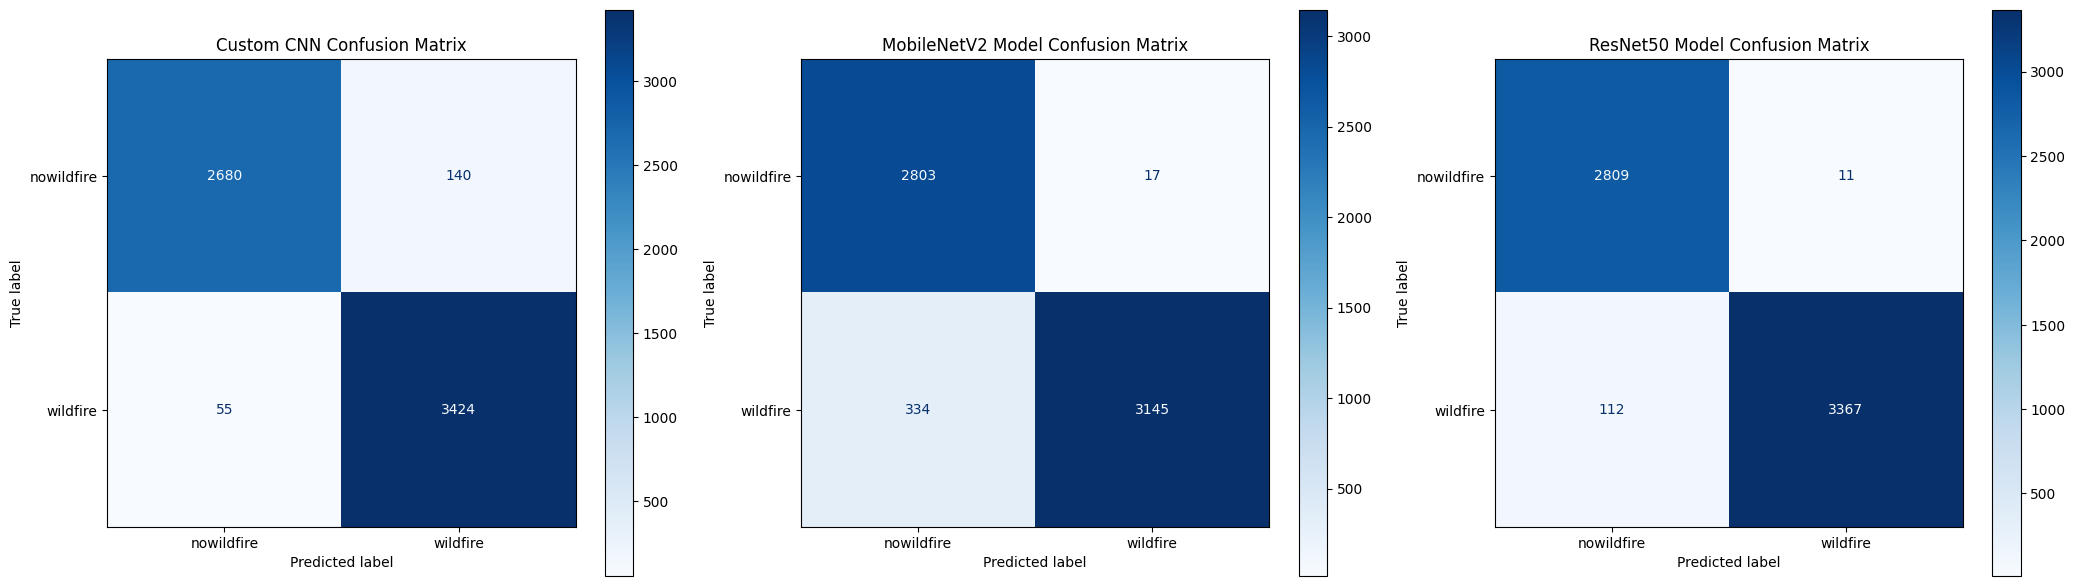

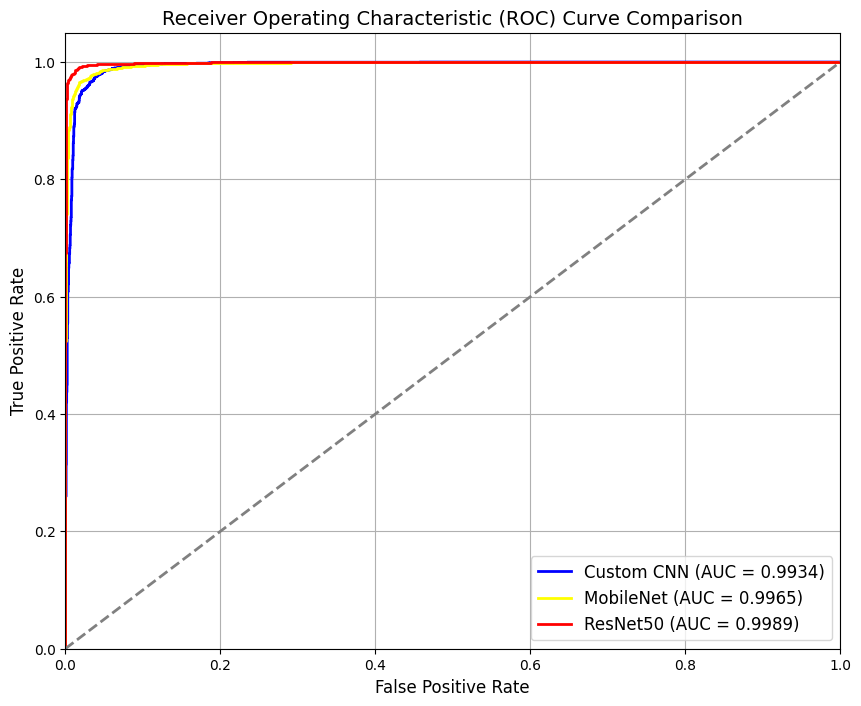

In [13]:
#Plots of Confusion Matrices(for each)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
#Custom CNN's plot
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_cnn, display_labels=class_names, ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Custom CNN Confusion Matrix')
#MobileNetV2's plot
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_transfer, display_labels=class_names, ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('MobileNetV2 Model Confusion Matrix')
#ResNet50's plot
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_resnet, display_labels=class_names, ax=axes[2], cmap=plt.cm.Blues)
axes[2].set_title('ResNet50 Model Confusion Matrix')
plt.tight_layout()
plt.show()

#ROC Curves
fpr_cnn, tpr_cnn, _ = roc_curve(y_true, y_pred_cnn_prob)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
fpr_transfer, tpr_transfer, _ = roc_curve(y_true, y_pred_transfer_prob)
roc_auc_transfer = auc(fpr_transfer, tpr_transfer)
fpr_resnet, tpr_resnet, _ = roc_curve(y_true, y_pred_resnet_prob)
roc_auc_resnet = auc(fpr_resnet, tpr_resnet)

plt.figure(figsize=(10, 8))
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'Custom CNN (AUC = {roc_auc_cnn:.4f})')
plt.plot(fpr_transfer, tpr_transfer, color='yellow', lw=2, label=f'MobileNet (AUC = {roc_auc_transfer:.4f})')
plt.plot(fpr_resnet, tpr_resnet, color='red', lw=2, label=f'ResNet50 (AUC = {roc_auc_resnet:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef)
import pandas as pd
print("Generating Final Performance Metrics Table")
model_predictions = {
    'Custom CNN': {
        'predictions': y_pred_cnn,
        'probabilities': y_pred_cnn_prob
    },
    'MobileNetV2': {
        'predictions': y_pred_transfer,
        'probabilities': y_pred_transfer_prob
    },
    'ResNet50':{
        'predictions': y_pred_resnet,
        'probabilities': y_pred_resnet_prob
    }
}
evaluation_results = []
for model_name, data in model_predictions.items():
  y_pred = data['predictions']
  y_prob = data['probabilities']
  cm = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.flatten() if cm.shape == (2,2) else (0,0,0,0)
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  auc_score = roc_auc_score(y_true, y_prob)
  f1 = f1_score(y_true, y_pred, pos_label=1)
  specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
  mcc = matthews_corrcoef(y_true, y_pred)
  evaluation_results.append({
      'Model': model_name,
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'AUC': auc_score,
      'F1 Score': f1,
      'Specificity': specificity,
      'MCC': mcc
  })
  results_df = pd.DataFrame(evaluation_results)
  results_df.set_index('Model', inplace=True)
print(results_df.round(4))
print("Evaluation is complete")

Generating Final Performance Metrics Table
             Accuracy  Precision  Recall     AUC  F1 Score  Specificity  \
Model                                                                     
Custom CNN     0.9690     0.9607  0.9842  0.9934    0.9723       0.9504   
MobileNetV2    0.9443     0.9946  0.9040  0.9965    0.9471       0.9940   
ResNet50       0.9805     0.9967  0.9678  0.9989    0.9821       0.9961   

                MCC  
Model                
Custom CNN   0.9376  
MobileNetV2  0.8930  
ResNet50     0.9611  
Evaluation is complete
